In [34]:
#Libraries
import pandas as pd
import pandas as pd
from surprise import Reader, Dataset, KNNWithMeans, accuracy, PredictionImpossible
from collections import defaultdict
from surprise.model_selection import KFold
from random import shuffle
import matplotlib.pyplot as plt

#Importing the data
data = pd.read_csv('/home/bbruno/all_here/python course/vinnie/data/cleaned_data/df_oversamling.csv')
data.head()

,userId,wine,rate
0,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Montepulciano 60,1
1,4e0cbfe3-8d73-4af4-b09e-f3193d1170a5,Zahorra Blanca,1
2,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
3,20e0b694-84a5-4f11-9191-598f924c2947,Morellino di Scansano 2021,1
4,5ccd8030-047b-432c-a630-d784ab415756,Bardolino Chiaretto,1


In [35]:
#metrics
metrics_df = pd.DataFrame(
    columns=['Index','Model','Metric','Optimizer','User_based',
             'RMSE','MAE','MSE', 'Precision', 'Recall', 'Accuracy'])
print(metrics_df)

Empty DataFrame
Columns: [Index, Model, Metric, Optimizer, User_based, RMSE, MAE, MSE, Precision, Recall, Accuracy]
Index: []


In [36]:
class KnnWithMeans (KNNWithMeans):
    def __init__(self, sim_options={}, bsl_options = {}):
        KNNWithMeans.__init__(self, sim_options=sim_options, bsl_options= bsl_options)
    
    def create_reader(self, data):
        reader = Reader(rating_scale=(1, 5))
        self.data = Dataset.load_from_df(data[['userId', 'wine', 'rate']], reader)
        
    def fit (self):
        '''Divide the data into train and test manually '''
        #Frist shuffle the data
        raw_ratings = self.data.raw_ratings
        shuffle(raw_ratings)
        
        #75% of the data for training and the rest for testing
        threshold = int(.80 * len(raw_ratings))
        train_raw_ratings = raw_ratings[:threshold]
        test_raw_ratings = raw_ratings[threshold:]
        
        #Update the data object with train raw ratings
        self.data.raw_ratings = train_raw_ratings
        
        #Define a cross-validation iterator
        kf = KFold(n_splits=5, shuffle= True, random_state=42)
        
        train_rmse_list = []
        test_rmse_list = []
        
        for trainset_fold, testset_fold in kf.split(self.data):
            #Train and test algorithm.
            KNNWithMeans.fit(self, trainset_fold)
            train_prediction = KNNWithMeans.test(self, trainset_fold.build_testset())
            prediction = KNNWithMeans.test(self, testset_fold)

            #Error on training
            train_rmse = accuracy.rmse(train_prediction)
            train_rmse_list.append(train_rmse)

            #Error on testing
            test_rmse = accuracy.rmse(prediction)
            test_rmse_list.append(test_rmse)

        avg_train_rmse = sum(train_rmse_list) / len(train_rmse_list)
        avg_test_rmse = sum(test_rmse_list) / len(test_rmse_list)
        print("###############################################")
        print("The Results are: \n")
        print(f"Average RMSE on Training Set: {avg_train_rmse}")
        print(f"Average RMSE on Test Set: {avg_test_rmse}")

        #Predict ratings for all pairs (u, i) that are NOT in the training set.
        #Update the data object with test raw ratings
        self.data.raw_ratings = test_raw_ratings
        #adapting the Testset to be compatible with Surprise
        testset = self.data.construct_testset(self.data.raw_ratings)
        #Predicting the ratings for testset
        predictions = KNNWithMeans.test(self, testset)
        #RMSE
        test_rmse = accuracy.rmse(predictions)
        print(f"RMSE on Test Set on UNSEEN DATA is RMSE, : {test_rmse}")

        self.sim = self.compute_similarities()
        self.bu, self.bi = self.compute_baselines()
        return predictions
    
    def get_user_name(self, uid):
        """Return the name of a user from their id.
        Args:
            uid(int): The raw id of the user.
        Returns:
            The name of the user.
        """
        return self.trainset.to_raw_uid(uid)
    
    def get_item_name(self, iid):
        """Return the name of an item from their id.
        Args:
            iid(int): The raw id of the item.
        Returns:
            The name of the item.
        """
        return self.trainset.to_raw_iid(iid)
    
    def get_neighbors_uid(self, user_id, k=10):
        '''Return the k nearest neighbors of user_id'''
        neighbor_ids = self.get_neighbors(user_id, k=10)
        neighbor_names = [self.get_user_name(uid) for uid in neighbor_ids]
        return neighbor_names
    def get_neighbors_iid(self, item_id, k=10):
        '''Return the k nearest neighbors of item_id'''
        neighbor_ids = self.get_neighbors(item_id, k=10)
        neighbor_names = [self.get_item_name(iid) for iid in neighbor_ids]
        return neighbor_names
        
    def get_top_n_for_user(self, predictions,user_id, n=10):
        """Return the top-N recommendation for a user from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            n(int): The number of recommendation to output for each user. Default
                is 10.

        Returns:
        A dict where keys are user (raw) ids and values are lists of tuples:
            [(raw item id, rating estimation), ...] of size n.
        """

        # First map the predictions to each user.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if uid == user_id:
                top_n[uid].append((iid, est))

        # Then sort the predictions for the user and retrieve the k highest ones.
        user_ratings = top_n[user_id]
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[user_id] = user_ratings[:n]

        return top_n[user_id]
    
    def get_top_n_users_for_item(self, predictions, item_id, n=10):
        """Return the top-N users for a specific item from a set of predictions.

        Args:
            predictions(list of Prediction objects): The list of predictions, as
                returned by the test method of an algorithm.
            item_id: The id of the item for which to get the top-N users.
            n(int): The number of users to output for the item. Default is 10.

        Returns:
        A list of tuples:
            [(raw user id, rating estimation), ...] of size n.
        """

        # First map the predictions to each item.
        top_n = defaultdict(list)
        for uid, iid, true_r, est, _ in predictions:
            if iid == item_id:
                top_n[iid].append((uid, est))

        # Then sort the predictions for the item and retrieve the k highest ones.
        item_ratings = top_n[item_id]
        item_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[item_id] = item_ratings[:n]

        return top_n[item_id]

    def estimated(self, u, i):
        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible("User and/or item is unknown.")
        
        #Compute similarities between u and v, where v describes all other
        #users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print("The 5 nearest neighbors of user", str(u), "are:")
        for v, sim_uv in neighbors[:5]:
            print(f"user {v} with sim {sim_uv:1.15f}")

        # ... Aaaaand return the baseline estimate anyway ;)
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return print(f"And the baseline estimate is: {bsl}")
    
    def get_Iu(self, uid):
        """Return the number of items rated by given user
        args:
          uid: the id of the user
        returns:
          the number of items rated by the user
        """
        try:
            return len(self.trainset.ur[self.trainset.to_inner_uid(uid)])
        except ValueError:  # user was not part of the trainset
            return 0

    def get_Ui(self, iid):
        """Return the number of users that have rated given item
        args:
          iid: the raw id of the item
        returns:
          the number of users that have rated the item.
        """
        try:
            return len(self.trainset.ir[self.trainset.to_inner_iid(iid)])
        except ValueError:
            return 0

    def inspect_predictions(self, predictions):
        print(f"uid means the user id and iid means the wine id\n")
        print(f"rui means the actual rating and est means the estimated rating\n")
        print(f"err means the error between the actual and the estimated rating\n")
        print(f"Iu means the number of items rated by given user\n")
        print(f"Ui means the number of users that have rated given item\n")
        # Create a dataframe with the predictions
        df_pred = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
        df_pred['Iu'] = df_pred.uid.apply(self.get_Iu)
        df_pred['Ui'] = df_pred.iid.apply(self.get_Ui)
        df_pred['err'] = abs(df_pred.est - df_pred.rui)
        return df_pred
    
    def get_accuracy(self, predictions, k=10, threshold=3.5):
        #Compute RMSE
        rmse = accuracy.rmse(predictions, verbose=True)
        #Compute MAE
        mae = accuracy.mae(predictions, verbose=True)
        # Compute MSE
        mse = accuracy.mse(predictions, verbose=True)

        #Compute precision and recall
        precisions, recalls = self.precision_recall_at_k(predictions, k=k, threshold=threshold)

        #Precision and recall can then be averaged over all users
        precision = sum(prec for prec in precisions.values()) / len(precisions)
        recall = sum(rec for rec in recalls.values()) / len(recalls)
        print(f'Precision: {precision:.2f}\nRecall: {recall:.2f}')

        #Count correct predictions
        correct = 0
        for uid, iid, true_r, est, _ in predictions:
            if round(est) == round(true_r):
                correct += 1

        #Compute accuracy
        accuracy_percentage = correct / len(predictions)
        accuracy_percentage = accuracy_percentage * 100
        print(f"the acc is {accuracy_percentage:.2f}")

        #Return a dictionary with the metrics
        return {'RMSE': rmse, 'MAE': mae, 'MSE': mse, 'Precision': precision, 'Recall': recall, 'Accuracy': accuracy_percentage}
        
    @staticmethod 
    def precision_recall_at_k(predictions, k=10, threshold=3.5):
        """Return precision and recall at k metrics for each user"""
        # First map the predictions to each user.
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions = dict()
        recalls = dict()
        for uid, user_ratings in user_est_true.items():
            # Sort user ratings by estimated value
            user_ratings.sort(key=lambda x: x[0], reverse=True)

            # Number of relevant items
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

            # Number of recommended items in top k
            n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

            # Number of relevant and recommended items in top k
            n_rel_and_rec_k = sum(
                ((true_r >= threshold) and (est >= threshold))
                for (est, true_r) in user_ratings[:k]
            )

            # Precision@K: Proportion of recommended items that are relevant
            # When n_rec_k is 0, Precision is undefined. We here set it to 0.
            precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

            # Recall@K: Proportion of relevant items that are recommended
            # When n_rel is 0, Recall is undefined. We here set it to 0.
            recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        return precisions, recalls

## KnnWithMeans SGD

* knn_with_means cosine, user based

In [37]:
knn_with_means = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means.create_reader(data)
predictions = knn_with_means.fit()
#acc
metrics = knn_with_means.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 1
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2636
RMSE: 0.7312
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2719
RMSE: 0.5968
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2676
RMSE: 0.7045
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2665
RMSE: 0.6290
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2482
RMSE: 0.6496
###############################################
The Results are: 

Average RMSE on Training Set: 0.2635651788577654
Average RMSE on Test Set: 0.6621950039734281
RMSE: 0.6473
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6473257765626457
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6473
MAE:  0.3572
MSE: 0.4190
Precision: 0.39
Recall: 0.35
the acc is 70.34


/tmp/ipykernel_17931/655597585.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* knn_with_means cosine, item based

In [38]:
knn_with_means2 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means2.create_reader(data)
predictions = knn_with_means2.fit()
#acc
metrics = knn_with_means2.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 2
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3001
RMSE: 0.7651
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3139
RMSE: 0.6857
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3217
RMSE: 0.6565
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3349
RMSE: 0.6317
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3319
RMSE: 0.6419
###############################################
The Results are: 

Average RMSE on Training Set: 0.3204960058700233
Average RMSE on Test Set: 0.6761866979116405
RMSE: 0.6110
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6110192398267358
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6110
MAE:  0.3246
MSE: 0.3733
Precision: 0.36
Recall: 0.31
the acc is 75.33


/tmp/ipykernel_17931/3877873262.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/3877873262.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared difference, user based

In [39]:
knn_with_means3 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means3.create_reader(data)
predictions = knn_with_means3.fit()
#acc
metrics = knn_with_means3.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 3
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2433
RMSE: 0.5891
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2443
RMSE: 0.6071
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2201
RMSE: 0.6668
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2131
RMSE: 0.6453
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2409
RMSE: 0.6321
###############################################
The Results are: 

Average RMSE on Training Set: 0.23234536098145334
Average RMSE on Test Set: 0.6280814369355772
RMSE: 0.5823
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5823030681299587
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.5823
MAE:  0.2958
MSE: 0.3391
Precision: 0.33
Recall: 0.30
the acc is 76.38


/tmp/ipykernel_17931/289524525.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/289524525.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans mean squared diference, item based

In [40]:
knn_with_means4 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means4.create_reader(data)
predictions = knn_with_means4.fit()
#acc
metrics = knn_with_means4.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 4
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2882
RMSE: 0.7349
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2795
RMSE: 0.6437
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2817
RMSE: 0.6016
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2764
RMSE: 0.6596
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2512
RMSE: 0.7458
###############################################
The Results are: 

Average RMSE on Training Set: 0.27538706927026485
Average RMSE on Test Set: 0.6771305720651413
RMSE: 0.6431
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6430731434317717
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6431
MAE:  0.3308
MSE: 0.4135
Precision: 0.42
Recall: 0.38
the acc is 74.80


/tmp/ipykernel_17931/2026458134.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/2026458134.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, user based

In [41]:
knn_with_means5 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means5.create_reader(data)
predictions = knn_with_means5.fit()
#acc
metrics = knn_with_means5.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 5
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1996
RMSE: 0.6338
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2001
RMSE: 0.6080
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1917
RMSE: 0.6230
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1693
RMSE: 0.6934
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1912
RMSE: 0.5166
###############################################
The Results are: 

Average RMSE on Training Set: 0.19037807092901823
Average RMSE on Test Set: 0.61496259202251
RMSE: 0.6213
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6213232260146494
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.6213
MAE:  0.3166
MSE: 0.3860
Precision: 0.36
Recall: 0.31
the acc is 73.49


/tmp/ipykernel_17931/2000926961.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/2000926961.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson, item based

In [42]:
knn_with_means6 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means6.create_reader(data)
predictions = knn_with_means6.fit()
#acc
metrics = knn_with_means6.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 6
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2375
RMSE: 0.6884
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1940
RMSE: 0.6222
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2174
RMSE: 0.6599
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2032
RMSE: 0.6682
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1855
RMSE: 0.6116
###############################################
The Results are: 

Average RMSE on Training Set: 0.20750695538161673
Average RMSE on Test Set: 0.6500637033931556
RMSE: 0.5693
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5692791583818118
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using sgd...
RMSE: 0.5693
MAE:  0.2814
MSE: 0.3241
Precision: 0.34
Recall: 0.28
the acc is 75.59


/tmp/ipykernel_17931/1753961335.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/1753961335.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [43]:
knn_with_means7 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means7.create_reader(data)
predictions = knn_with_means7.fit()
#acc
metrics = knn_with_means7.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 7
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1912
RMSE: 0.5664
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1867
RMSE: 0.5839
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1848
RMSE: 0.6463
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1763
RMSE: 0.6189
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1164
RMSE: 0.7414
###############################################
The Results are: 

Average RMSE on Training Set: 0.1710956196135743
Average RMSE on Test Set: 0.6313877023046917
RMSE: 0.6330
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.633024833882492
Computing the pearson_baseline similarity matrix..

/tmp/ipykernel_17931/101808052.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/101808052.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [44]:
knn_with_means8 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'sgd', 'learning_rate': 0.05, 'n_epochs':60, 'reg_u': 12 , 'reg_i': 5}
    )
knn_with_means8.create_reader(data)
predictions = knn_with_means8.fit()
#acc
metrics = knn_with_means8.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 8
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'SGD'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)


Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1561
RMSE: 0.7122
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1887
RMSE: 0.6128
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1841
RMSE: 0.6124
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1755
RMSE: 0.7088
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1884
RMSE: 0.6404
###############################################
The Results are: 

Average RMSE on Training Set: 0.17856501931527785
Average RMSE on Test Set: 0.6573264609579376
RMSE: 0.7158
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.7158223102663248
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17931/1437423512.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/1437423512.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


## KnnWithMeans Alternating Least Squares (ALS)

* KnnWithMeans cosine, user based

In [45]:
knn_with_means9 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means9.create_reader(data)
predictions = knn_with_means9.fit()
#acc
metrics = knn_with_means9.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 9
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2555
RMSE: 0.6562
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2602
RMSE: 0.6330
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2613
RMSE: 0.7513
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2786
RMSE: 0.5891
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.2659
RMSE: 0.6492
###############################################
The Results are: 

Average RMSE on Training Set: 0.2643007286932727
Average RMSE on Test Set: 0.655774801474546
RMSE: 0.6934
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6933747659472594
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6934
MAE:  0.3678
MSE: 0.4808
Precision: 0.37
Recall: 0.33
the acc is 70.60


/tmp/ipykernel_17931/1812438443.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/1812438443.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans cosine, item based

In [46]:
knn_with_means10 = KnnWithMeans(
    sim_options = {'name': 'cosine','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means10.create_reader(data)
predictions = knn_with_means10.fit()
#acc
metrics = knn_with_means10.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 10
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'Cosine'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3048
RMSE: 0.6817
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3098
RMSE: 0.6622
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3177
RMSE: 0.6104
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3077
RMSE: 0.7069
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.3100
RMSE: 0.6717
###############################################
The Results are: 

Average RMSE on Training Set: 0.31001734463691955
Average RMSE on Test Set: 0.6665861354503543
RMSE: 0.6670
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6669708713542212
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6670
MAE:  0.3770
MSE: 0.4449
Precision: 0.36
Recall: 0.28
the acc is 69.29


/tmp/ipykernel_17931/3298270025.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/3298270025.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeansWithMeans mean squared difference, user based

In [47]:
knn_with_means11 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means11.create_reader(data)
predictions = knn_with_means11.fit()
#acc
metrics = knn_with_means11.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 11
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2221
RMSE: 0.6206
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2076
RMSE: 0.5828
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2274
RMSE: 0.6306
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2405
RMSE: 0.6396
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2119
RMSE: 0.6560
###############################################
The Results are: 

Average RMSE on Training Set: 0.22192315940683213
Average RMSE on Test Set: 0.6259105409893561
RMSE: 0.6336
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6335874008031924
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6336
MAE:  0.3332
MSE: 0.4014
Precision: 0.33
Recall: 0.28
the acc is 72.97


/tmp/ipykernel_17931/4069916643.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/4069916643.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeansWithMeans mean squared difference, item based

In [48]:
knn_with_means12 = KnnWithMeans(
    sim_options = {'name': 'msd','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means12.create_reader(data)
predictions = knn_with_means12.fit()
#acc
metrics = knn_with_means12.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 12
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'MSD'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2703
RMSE: 0.7230
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2711
RMSE: 0.6234
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2580
RMSE: 0.6049
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2614
RMSE: 0.6546
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.2672
RMSE: 0.6713
###############################################
The Results are: 

Average RMSE on Training Set: 0.26560612562272307
Average RMSE on Test Set: 0.6554177606788014
RMSE: 0.6820
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.681992456861618
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6820
MAE:  0.3566
MSE: 0.4651
Precision: 0.32
Recall: 0.27
the acc is 72.97


/tmp/ipykernel_17931/3923251051.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/3923251051.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, user based

In [49]:
knn_with_means13 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means13.create_reader(data)
predictions = knn_with_means13.fit()
#acc
metrics = knn_with_means13.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 13
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1945
RMSE: 0.6713
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2077
RMSE: 0.5857
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1967
RMSE: 0.7282
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1976
RMSE: 0.6884
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1659
RMSE: 0.6301
###############################################
The Results are: 

Average RMSE on Training Set: 0.19247675505514478
Average RMSE on Test Set: 0.66074766770504
RMSE: 0.5304
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5303828485031639
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.5304
MAE:  0.2421
MSE: 0.2813
Precision: 0.38
Recall: 0.34
the acc is 78.74


/tmp/ipykernel_17931/3977358235.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/3977358235.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans pearson correlation coefficient, item based

In [50]:
knn_with_means14 = KnnWithMeans(
    sim_options = {'name': 'pearson','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means14.create_reader(data)
predictions = knn_with_means14.fit()
#acc
metrics = knn_with_means14.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 14
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = 'pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1836
RMSE: 0.6860
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2032
RMSE: 0.5519
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2287
RMSE: 0.6079
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.1716
RMSE: 0.6851
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.2237
RMSE: 0.6791
###############################################
The Results are: 

Average RMSE on Training Set: 0.20212738238468458
Average RMSE on Test Set: 0.6420120892943955
RMSE: 0.6088
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.608775127451121
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
RMSE: 0.6088
MAE:  0.3001
MSE: 0.3706
Precision: 0.41
Recall: 0.35
the acc is 76.64


/tmp/ipykernel_17931/2985716342.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/2985716342.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, user based

In [51]:
knn_with_means15 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': True}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means15.create_reader(data)
predictions = knn_with_means15.fit()
#acc
metrics = knn_with_means15.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 15
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = True

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1848
RMSE: 0.5782
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1903
RMSE: 0.6204
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1522
RMSE: 0.6718
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1791
RMSE: 0.5976
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1622
RMSE: 0.6293
###############################################
The Results are: 

Average RMSE on Training Set: 0.17373208423459552
Average RMSE on Test Set: 0.6194299173844763
RMSE: 0.6154
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.6153994767112458
Computing the pearson_baseline similarity matrix

/tmp/ipykernel_17931/1732976370.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/1732976370.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


* KnnWithMeans (shrunk) pearson correlation coefficient, item based

In [52]:
knn_with_means16 = KnnWithMeans(
    sim_options = {'name': 'pearson_baseline','user_based': False}, 
    bsl_options={'method': 'als', 'n_epochs':60}
    )
knn_with_means16.create_reader(data)
predictions = knn_with_means16.fit()
#acc
metrics = knn_with_means16.get_accuracy(predictions)

# Add the model name to the dictionary
metrics['Index'] = 16
metrics['Model'] = 'KnnWithMeans'
metrics['Metric'] = '(shrunk) pearson corr coeff'
metrics['Optimizer'] = 'ALS'
metrics['User_based'] = False

# Append the dictionary to the existing DataFrame
metrics_df = metrics_df.append(metrics, ignore_index=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1795
RMSE: 0.6816
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1272
RMSE: 0.6976
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1803
RMSE: 0.6235
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1778
RMSE: 0.7019
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.1752
RMSE: 0.6033
###############################################
The Results are: 

Average RMSE on Training Set: 0.16799794973525067
Average RMSE on Test Set: 0.661570526943297
RMSE: 0.5898
RMSE on Test Set on UNSEEN DATA is RMSE, : 0.5898385965872476
Computing the pearson_baseline similarity matrix.

/tmp/ipykernel_17931/3559677741.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)
/tmp/ipykernel_17931/3559677741.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  metrics_df = metrics_df.append(metrics, ignore_index=True)


In [53]:
metrics_df.sort_values(by='RMSE', ascending=True, inplace=True)
metrics_df

,Index,Model,Metric,Optimizer,User_based,RMSE,MAE,MSE,Precision,Recall,Accuracy
12,13,KnnWithMeans,pearson corr coeff,ALS,True,0.530383,0.242089,0.281306,0.382353,0.339217,78.740157
5,6,KnnWithMeans,pearson corr coeff,SGD,False,0.569279,0.281395,0.324079,0.339130,0.282787,75.590551
2,3,KnnWithMeans,MSD,SGD,True,0.582303,0.295825,0.339077,0.325581,0.301606,76.377953
15,16,KnnWithMeans,(shrunk) pearson corr coeff,ALS,False,0.589839,0.308791,0.347910,0.381481,0.331890,74.015748
13,14,KnnWithMeans,pearson corr coeff,ALS,False,0.608775,0.300140,0.370607,0.410256,0.350597,76.640420
1,2,KnnWithMeans,Cosine,SGD,False,0.611019,0.324560,0.373345,0.361789,0.306696,75.328084
14,15,KnnWithMeans,(shrunk) pearson corr coeff,ALS,True,0.615399,0.314890,0.378717,0.337258,0.287890,73.490814
4,5,KnnWithMeans,pearson corr coeff,SGD,True,0.621323,0.316574,0.386043,0.364314,0.310644,73.490814
6,7,KnnWithMeans,(shrunk) pearson corr coeff,SGD,True,0.633025,0.304014,0.400720,0.413813,0.347896,76.902887
10,11,KnnWithMeans,MSD,ALS,True,0.633587,0.333168,0.401433,0.329060,0.281396,72.965879


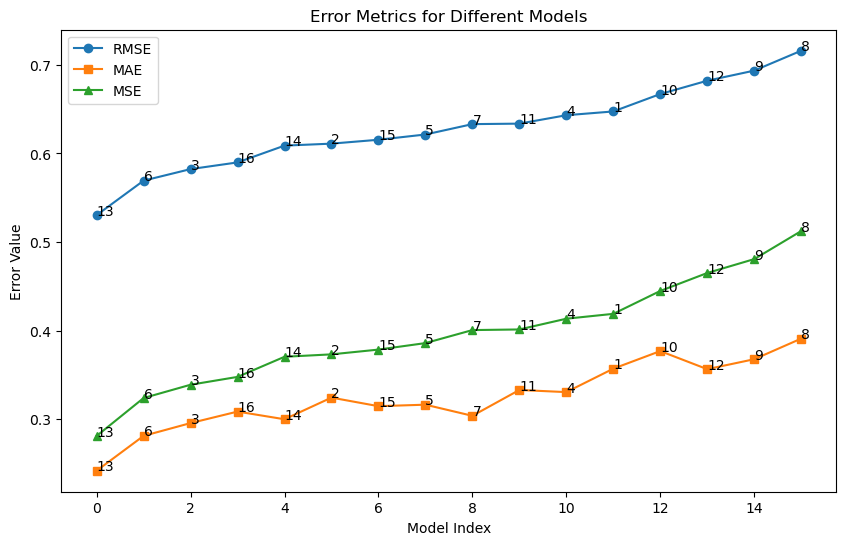

In [54]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MAE'], marker='s', linestyle='-', label='MAE')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['MSE'], marker='^', linestyle='-', label='MSE')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MAE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['MSE'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

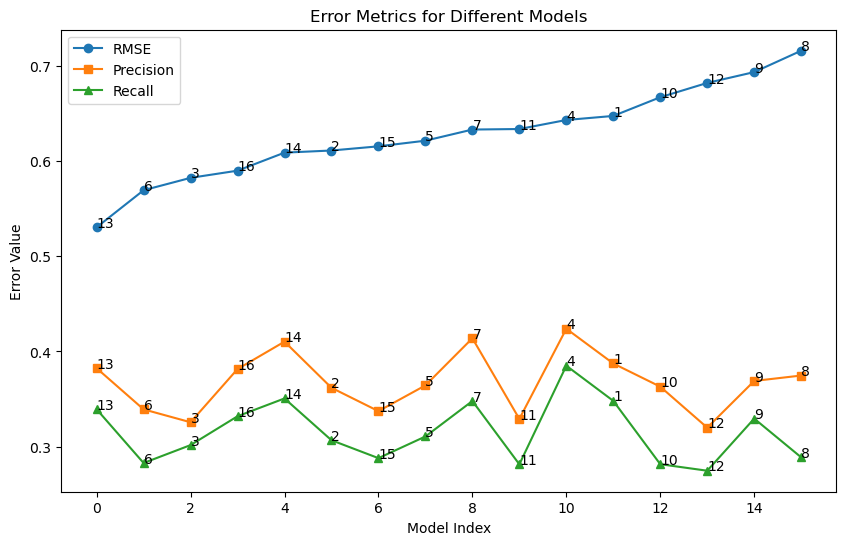

In [55]:
plt.figure(figsize=(10, 6))

#Plot RMSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['RMSE'], marker='o', linestyle='-', label='RMSE')

#Plot MAE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Precision'], marker='s', linestyle='-', label='Precision')

#Plot MSE with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Recall'], marker='^', linestyle='-', label='Recall')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['RMSE'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Precision'].iloc[i]))
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Recall'].iloc[i]))

#Setting title and labels
plt.title('Error Metrics for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Error Value')

#legend
plt.legend()
plt.show()

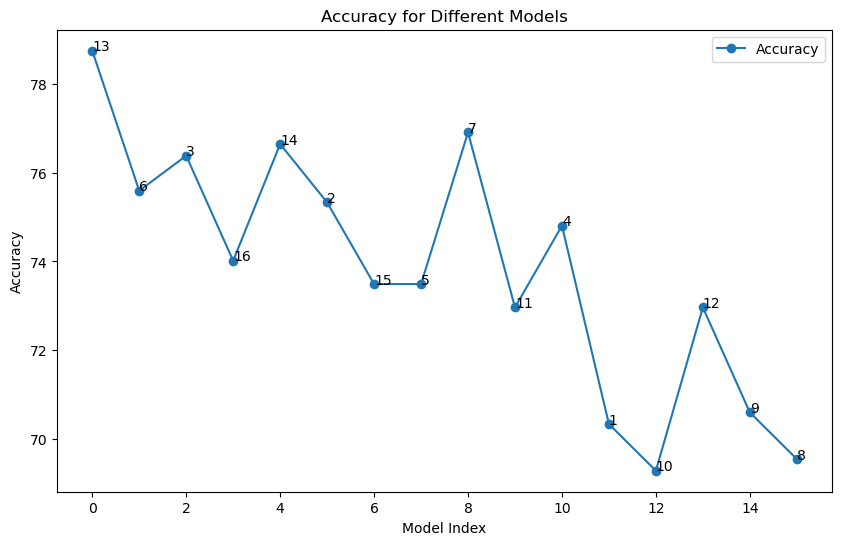

In [56]:
plt.figure(figsize=(10, 6))

#Plot Accuracy with lines and points
plt.plot(range(metrics_df.shape[0]), metrics_df['Accuracy'], marker='o', linestyle='-', label='Accuracy')

#Annotate points with 'Index' column values
for i in range(metrics_df.shape[0]):
    plt.annotate(metrics_df['Index'].iloc[i], (i, metrics_df['Accuracy'].iloc[i]))

#Setting title and labels
plt.title('Accuracy for Different Models')
plt.xlabel('Model Index')
plt.ylabel('Accuracy')

#legend
plt.legend()
plt.show()

## Estimates

In [57]:
#recommends items for a given user from predictions

# user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
# top_n = KnnWithMeans.get_top_n_for_user(predictions, user_id)
# print(user_id, [iid for (iid, _) in top_n])
######### better print
user_id = '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7'
top_n = knn_with_means.get_top_n_for_user(predictions, user_id)
print(f"Top items for the user '{user_id}' are:")
for i, (iid, _) in enumerate(top_n, 1):
    print(f"{i}. Item ID: {iid}")

Top items for the user '7f6dede6-b8b5-4bb6-a1ca-ae58c79c0ea7' are:
1. Item ID: Le Relais de Patache d'Aux
2. Item ID: Les Pierrelles Crozes-Hermitage
3. Item ID: Chenin Blanc Secateurs
4. Item ID: Marlborough
5. Item ID: Clos la Laterne
6. Item ID: Senorino de Baldios
7. Item ID: Valle de Maipo Carmenere
8. Item ID: Yellow Label 
9. Item ID: Beyerskloof Western Cape
10. Item ID: Valle de Maipo Carmenere


In [58]:
# recommneds users for a given item from predictions

# item_id = 'Chardonnay'
# top_n = KnnWithMeans.get_top_n_users_for_item(predictions, item_id)
# print(item_id, [uid for (uid, _) in top_n])
########## better print
item_id = 'Chardonnay'
top_n = knn_with_means.get_top_n_users_for_item(predictions, item_id)
print(f"Top users for the item '{item_id}' are:")
for i, (uid, _) in enumerate(top_n, 1):
    print(f"{i}. User ID: {uid}")

Top users for the item 'Chardonnay' are:
1. User ID: 5ccd8030-047b-432c-a630-d784ab415756
2. User ID: 91cf68cc-9436-43e1-871d-33beef4d2337
3. User ID: 91cf68cc-9436-43e1-871d-33beef4d2337
4. User ID: 518f9753-12b1-4987-b651-38944fc33d07
5. User ID: 9c85a219-a94e-4b78-b300-ea65e52e9c6e


In [59]:
#get the KnnWithMeans for a user from the model
knn_with_means.get_neighbors_uid(user_id=5)

['e2723dcb-0b44-477f-bf74-678640f5c06d',
 '13016d41-00bd-411c-83f5-2b95691696b7',
 '76b71bb0-6cc9-4168-8a45-bbafc1e9a256',
 '990f0572-c5e7-47ec-ba20-141ab6058369',
 'c88644be-2c9b-42f0-9c4b-7f8e81795f43',
 '71d38b96-326c-4d01-afc4-b12c947a5c6b',
 '441ac739-42f8-48d2-9526-fdedf2d4852f',
 '9a3cc655-c88e-4c1b-95e2-add7579ff4c2',
 'defee34b-7775-4889-b703-92b730d85e70',
 'bc8f3005-c2c6-4277-9fd7-340248f4e7ec']

In [60]:
#get the KnnWithMeans for an item from the model
knn_with_means.get_neighbors_iid(item_id=20)

['Vistamar Cabernet Sauvignon Reserva',
 'Terrano',
 'le vigne di zamo refosco',
 'Chianti',
 'Pinot grigio',
 'Malvasia',
 'Spier Cabernet Sauvignon',
 'Weissburgunder Trocken',
 '3/11 Syrah and blend #7',
 'Conde de Valdemar Crianza']

In [61]:
knn_with_means.estimated(13,20)
print('\n#####\n')
print("Note: If the baseline is {} then the value is a default value, Otherwise not".format(knn_with_means.trainset.global_mean))

The 5 nearest neighbors of user 13 are:
user 2 with sim 0.000000000000000
user 2 with sim 0.000000000000000
And the baseline estimate is: 3.0742382468789238

#####

Note: If the baseline is 3.001639344262295 then the value is a default value, Otherwise not


In [62]:
df_pred = knn_with_means.inspect_predictions(predictions)
best_pred = df_pred.sort_values(by='err')[:10]
worst_pred = df_pred.sort_values(by='err')[-10:]
df_pred.head(10)

uid means the user id and iid means the wine id

rui means the actual rating and est means the estimated rating

err means the error between the actual and the estimated rating

Iu means the number of items rated by given user

Ui means the number of users that have rated given item



,uid,iid,rui,est,details,Iu,Ui,err
0,c26b57e2-bb71-43ca-b5bd-361867658d42,Les Terrasses Côtes du Roussillon Villages,3.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",1,1,0.000820
1,c88644be-2c9b-42f0-9c4b-7f8e81795f43,Terrano,1.0,1.000000,"{'actual_k': 12, 'was_impossible': False}",15,32,0.000000
2,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Friulano,1.0,1.377604,"{'actual_k': 40, 'was_impossible': False}",104,21,0.377604
3,5ccd8030-047b-432c-a630-d784ab415756,Scheurebe Gleisweiler,3.0,3.000841,"{'actual_k': 36, 'was_impossible': False}",122,3,0.000841
4,d838a526-4b0a-4fad-b54f-90b6ca321fca,Pinot Noir,3.0,3.000000,"{'actual_k': 2, 'was_impossible': False}",3,7,0.000000
5,bc79b0e3-064d-4240-86de-e86499f577e8,Les Grands Blancs,2.0,2.000000,"{'actual_k': 40, 'was_impossible': False}",96,4,0.000000
6,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Nus Malvoisie,2.0,1.947911,"{'actual_k': 40, 'was_impossible': False}",104,5,0.052089
7,f7fb310d-87f1-441a-94ab-f526f66b9ec1,'Cuvée des Paladins' Erbaluce di Caluso,5.0,5.000000,"{'actual_k': 1, 'was_impossible': False}",1,1,0.000000
8,457b85f5-7b46-4f52-85b9-59acb549b9a2,Limniona Rosé,4.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",9,1,1.000820
9,5ccd8030-047b-432c-a630-d784ab415756,Chardonnay,4.0,3.346794,"{'actual_k': 40, 'was_impossible': False}",122,10,0.653206


* best predictions

In [63]:
best_pred

,uid,iid,rui,est,details,Iu,Ui,err
190,91cf68cc-9436-43e1-871d-33beef4d2337,Chateau De La Riviere Sauvignon Blanc,3.0,3.0,"{'actual_k': 7, 'was_impossible': False}",50,1,0.0
203,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,le vigne di zamo refosco,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",104,8,0.0
204,e2723dcb-0b44-477f-bf74-678640f5c06d,Terrano,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",3,32,0.0
205,2a62eecd-b0cd-4395-9f8c-7c912a208be2,Organic pinot grigio terre siciliane igt,5.0,5.0,"{'actual_k': 32, 'was_impossible': False}",54,2,0.0
214,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Merlot le vigne di zamo,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",104,15,0.0
215,dc90e649-113d-4cec-983e-d03a7d4acff3,Cabernet Sauvignon,5.0,5.0,"{'actual_k': 1, 'was_impossible': False}",2,6,0.0
216,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 6,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",96,11,0.0
218,bc79b0e3-064d-4240-86de-e86499f577e8,3／4 大亂鬥 11,1.0,1.0,"{'actual_k': 40, 'was_impossible': False}",96,16,0.0
219,bc79b0e3-064d-4240-86de-e86499f577e8,2／17 @home #5,5.0,5.0,"{'actual_k': 17, 'was_impossible': False}",96,2,0.0
223,f8c400a6-ded1-40b8-95d2-a263d05c30ce,Kerner,4.0,4.0,"{'actual_k': 0, 'was_impossible': False}",135,2,0.0


* worst predictions

In [64]:
worst_pred

,uid,iid,rui,est,details,Iu,Ui,err
342,ecc462e1-5041-43ca-94c3-c2bfc9b3215e,Ribolla Gialla,2.0,3.449207,"{'actual_k': 40, 'was_impossible': False}",104,5,1.449207
368,83128cf9-f07f-4de1-97cf-cbde8d38bc3c,Odessa Black,5.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",5,2,2.000820
326,3da6eec4-bd99-4370-be23-676baf750f19,Rascal,5.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",1,0,2.000820
46,25a04c51-5638-42f0-b2e7-ce49b1c280fc,Cinque Terre,5.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",10,2,2.000820
94,83128cf9-f07f-4de1-97cf-cbde8d38bc3c,Odessa Black,5.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",5,2,2.000820
131,8764df8a-0919-433c-beab-053a9c12f402,Nero d'Avola Sicilia,5.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",1,1,2.000820
307,37239e04-c632-4373-805f-25d85ee1c9f0,La Cerbaiola,5.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",2,2,2.000820
259,bc79b0e3-064d-4240-86de-e86499f577e8,Boscarelli Vino Nobile de Montepulciano DOCG,5.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",96,0,2.000820
160,83128cf9-f07f-4de1-97cf-cbde8d38bc3c,Odessa Black,5.0,2.999180,"{'was_impossible': True, 'reason': 'User and/o...",5,2,2.000820
135,014e4ed1-6f8b-4b25-917d-c167a2acca17,New Wine,4.0,1.000000,"{'actual_k': 8, 'was_impossible': False}",9,10,3.000000
